In [2]:
import warnings

In [3]:
warnings.filterwarnings("ignore")

In [314]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

In [5]:
data = pd.read_csv("../NullValueHandled/NuwaraEliyaHandledNullValues.csv", index_col=0, parse_dates=True)

In [12]:
data.head()

,Next Date,HCHO reading
Current Date,,
2019-01-01,2019-01-02,0.000191
2019-01-02,2019-01-03,0.000191
2019-01-03,2019-01-04,0.000191
2019-01-04,2019-01-05,0.000051
2019-01-05,2019-01-06,0.000065


In [13]:
NuwaraEliya_data = data[["HCHO reading"]]
NuwaraEliya_data.head() 

,HCHO reading
Current Date,
2019-01-01,0.000191
2019-01-02,0.000191
2019-01-03,0.000191
2019-01-04,0.000051
2019-01-05,0.000065


In [14]:
NuwaraEliya_data.shape

(1826, 1)

In [15]:
X = NuwaraEliya_data.values

#### This looks like that Nuwara Eliya fomaldihyde rates have a seasonality

<Axes: xlabel='Current Date'>

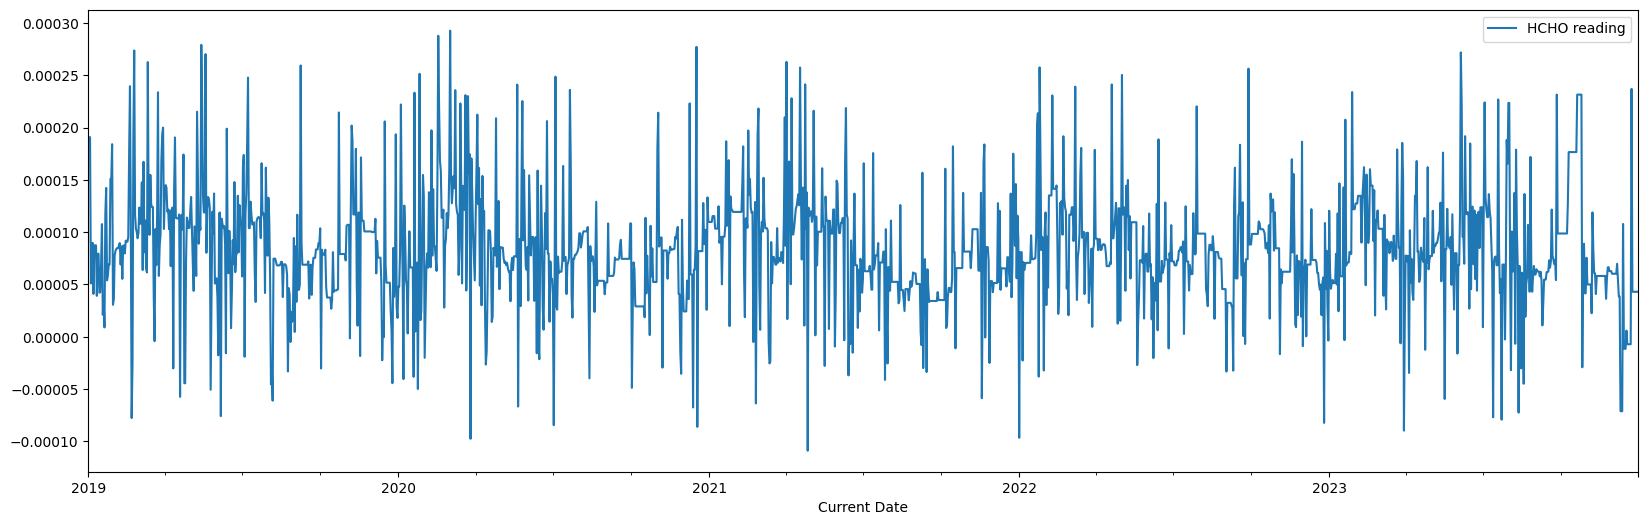

In [97]:
NuwaraEliya_data.plot(figsize=(20, 6))

In [17]:
from statsmodels.tsa.stattools import adfuller

In [19]:
test_nuwaraeliya = adfuller(NuwaraEliya_data["HCHO reading"], autolag="AIC")

In [20]:
print("ADF value : ", test_nuwaraeliya[0])
print("P value: ", test_nuwaraeliya[1])
print("Num of Lags :", test_nuwaraeliya[2])
print("Num of Observations used for ADF Regression and Critical Calculation :", test_nuwaraeliya[3])
for key, val in test_nuwaraeliya[4].items():
    print("\t", key, ": ", val)

ADF value :  -7.806557397054526
P value:  7.255531724210168e-12
Num of Lags : 10
Num of Observations used for ADF Regression and Critical Calculation : 1815
	 1% :  -3.4339580289794225
	 5% :  -2.8631337437669275
	 10% :  -2.567618456010139


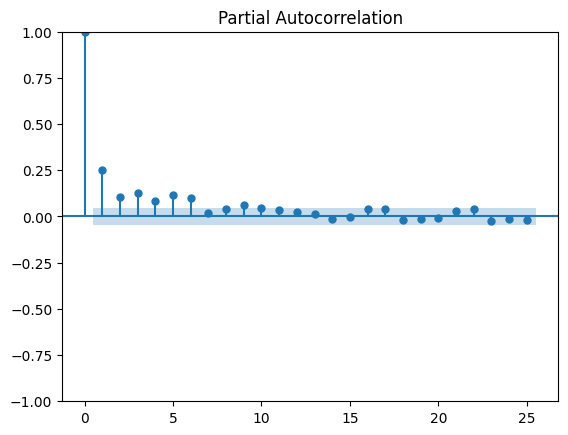

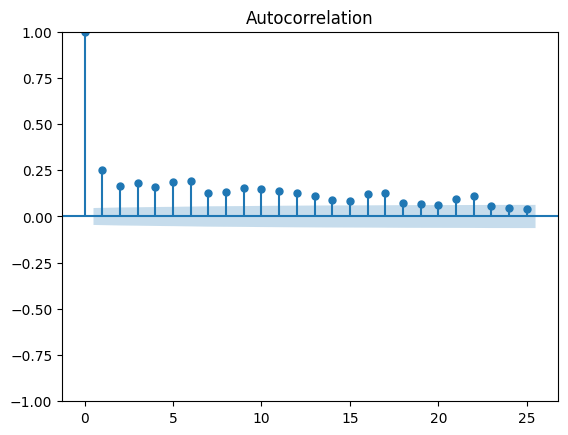

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(NuwaraEliya_data["HCHO reading"], lags=25)
acf = plot_acf(NuwaraEliya_data["HCHO reading"], lags=25) 

#### It shows there is a small seasanolity in the nuwara eliya dataset,however the partial Auto correlation plot shows there is a stationarity as well.

In [30]:
train=X[:1460]
test=X[1460:]

In [31]:
train[:5]

array([[1.90829389e-04],
       [1.90829389e-04],
       [1.90829389e-04],
       [5.09762592e-05],
       [6.45664550e-05]])

#### Check with Auto Regression Model 

In [54]:
# Import necessary libraries
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import AutoReg

# Assuming train is already defined as a numpy array

# Define the scaler
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform it
scaler.fit(train.reshape(-1, 1))
train_normalized = scaler.transform(train.reshape(-1, 1))

# Convert the normalized data back to a numpy array
train_normalized = train_normalized.flatten()

# Train the AutoReg model
model = AutoReg(train_normalized, lags=25).fit()

In [55]:
# Make predictions using the trained model
predicted_normalized = model.predict(start=len(train_normalized), end=len(train_normalized) + len(test) - 1, dynamic=False)

# Inverse transform the predicted values to the original scale
predicted_values = scaler.inverse_transform(predicted_normalized.reshape(-1, 1)).flatten()

# Create a DataFrame for predicted values
predicted_df = pd.DataFrame(predicted_values, columns=['predicted'])

test = pd.DataFrame(test)
# Set the index of the predicted DataFrame to match the test data index
predicted_df.index = test.index

# Add the actual values from the test set to the DataFrame
predicted_df['actual'] = test

# Display the DataFrame with predicted and actual values
print(predicted_df.head())

   predicted    actual
0   0.000052 -0.000004
1   0.000054  0.000121
2   0.000072  0.000063
3   0.000057  0.000046
4   0.000057  0.000051


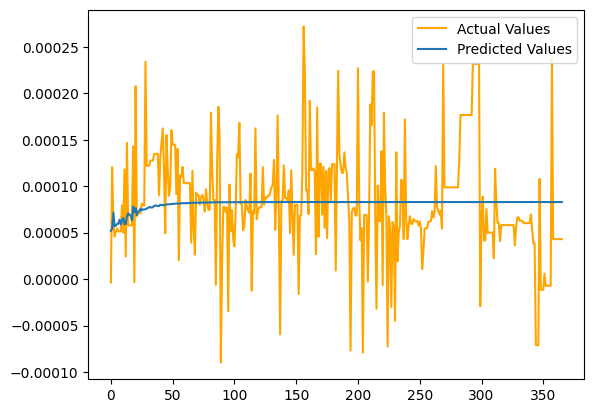

In [56]:
from matplotlib import pyplot

pyplot.plot(test, color="orange", label='Actual Values')
pyplot.plot(predicted_values, label='Predicted Values')
pyplot.legend()

#### There is a fluctuation of the values, but it cannot findout the pattern properly

In [57]:
from tabulate import tabulate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

# Assuming you have your test and predicted values stored in 'test' and 'predicted_values' variables

# Calculate the metrics
r_squared = r2_score(test, predicted_values)
mae = mean_absolute_error(test, predicted_values)
mse = mean_squared_error(test, predicted_values)
rmse = mean_squared_error(test, predicted_values, squared=False)
median_absolute = median_absolute_error(test, predicted_values)
explained_variance = explained_variance_score(test, predicted_values)

table_headers = ["Metric", "Value"]
table_data = {
    "R-squared (Coefficient of Determination)": "{:.12f}".format(r_squared),
    "Mean Absolute Error (MAE)": "{:.12f}".format(mae),
    "Mean Squared Error (MSE)": "{:.12f}".format(mse),
    "Root Mean Squared Error (RMSE)": "{:.12f}".format(rmse),
    "Median Absolute Error": "{:.12f}".format(median_absolute),
    "Explained Variance Score": "{:.12f}".format(explained_variance)
}

# Create DataFrame
df = pd.DataFrame(table_data.items(), columns=table_headers)

df

,Metric,Value
0,R-squared (Coefficient of Determination),-0.002890420843
1,Mean Absolute Error (MAE),0.000041806513
2,Mean Squared Error (MSE),0.000000003358
3,Root Mean Squared Error (RMSE),0.000057947750
4,Median Absolute Error,0.000028070465
5,Explained Variance Score,-0.000492248450


#### Nuwara Eliya with LSTM

In [514]:
data = pd.read_csv("../NullValueHandled/NuwaraEliyaHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [515]:
print(data.head())

  Current Date  HCHO reading
0   2019-01-01      0.000191
1   2019-01-02      0.000191
2   2019-01-03      0.000191
3   2019-01-04      0.000051
4   2019-01-05      0.000065


In [516]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# Assuming 'data' is your DataFrame and you've loaded it successfully

# Preprocess data
data['Current Date'] = pd.to_datetime(data['Current Date'])
data.sort_values(by='Current Date', inplace=True)
data.set_index('Current Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Normalize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Define function to create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length]) 
    return np.array(X), np.array(y) 

sequence_length = 5
# Create sequences for training and testing data
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)
 
model = Sequential([
    Bidirectional(LSTM(units=500, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(units=400, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=200, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=100, return_sequences=True)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Bidirectional(LSTM(units=10)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=1)
])

optimizer = RMSprop(learning_rate=0.005) 
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
37/37 [==============================] - 41s 445ms/step - loss: 1.0983 - mean_squared_error: 1.0983 - val_loss: 1.1683 - val_mean_squared_error: 1.1683
Epoch 2/100
37/37 [==============================] - 5s 134ms/step - loss: 1.0698 - mean_squared_error: 1.0698 - val_loss: 1.4894 - val_mean_squared_error: 1.4894
Epoch 3/100
37/37 [==============================] - 5s 133ms/step - loss: 1.0580 - mean_squared_error: 1.0580 - val_loss: 0.6984 - val_mean_squared_error: 0.6984
Epoch 4/100
37/37 [==============================] - 5s 135ms/step - loss: 1.0586 - mean_squared_error: 1.0586 - val_loss: 0.5862 - val_mean_squared_error: 0.5862
Epoch 5/100
37/37 [==============================] - 5s 136ms/step - loss: 1.0257 - mean_squared_error: 1.0257 - val_loss: 0.5911 - val_mean_squared_error: 0.5911
Epoch 6/100
37/37 [==============================] - 5s 129ms/step - loss: 1.0179 - mean_squared_error: 1.0179 - val_loss: 0.5831 - val_mean_squared_error: 0.5831
Epoch 7/100
37/37 [==

37/37 [==============================] - 5s 129ms/step - loss: 0.8862 - mean_squared_error: 0.8862 - val_loss: 0.6263 - val_mean_squared_error: 0.6263
Epoch 52/100
37/37 [==============================] - 5s 130ms/step - loss: 0.9155 - mean_squared_error: 0.9155 - val_loss: 0.6274 - val_mean_squared_error: 0.6274
Epoch 53/100
37/37 [==============================] - 5s 132ms/step - loss: 0.8919 - mean_squared_error: 0.8919 - val_loss: 0.6284 - val_mean_squared_error: 0.6284
Epoch 54/100
37/37 [==============================] - 5s 131ms/step - loss: 0.8784 - mean_squared_error: 0.8784 - val_loss: 0.6300 - val_mean_squared_error: 0.6300
Epoch 55/100
37/37 [==============================] - 5s 135ms/step - loss: 0.8905 - mean_squared_error: 0.8905 - val_loss: 0.6000 - val_mean_squared_error: 0.6000
Epoch 56/100
37/37 [==============================] - 5s 146ms/step - loss: 0.8957 - mean_squared_error: 0.8957 - val_loss: 0.6440 - val_mean_squared_error: 0.6440
Epoch 57/100
37/37 [=========

12/12 [==============================] - 6s 37ms/step


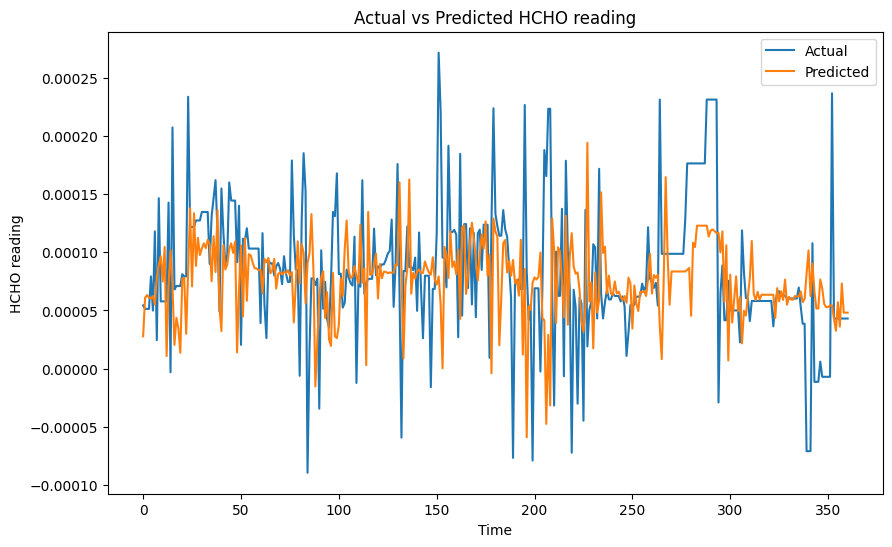

In [517]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [518]:
predictions.shape 

(361, 1)

46/46 [==============================] - 2s 35ms/step


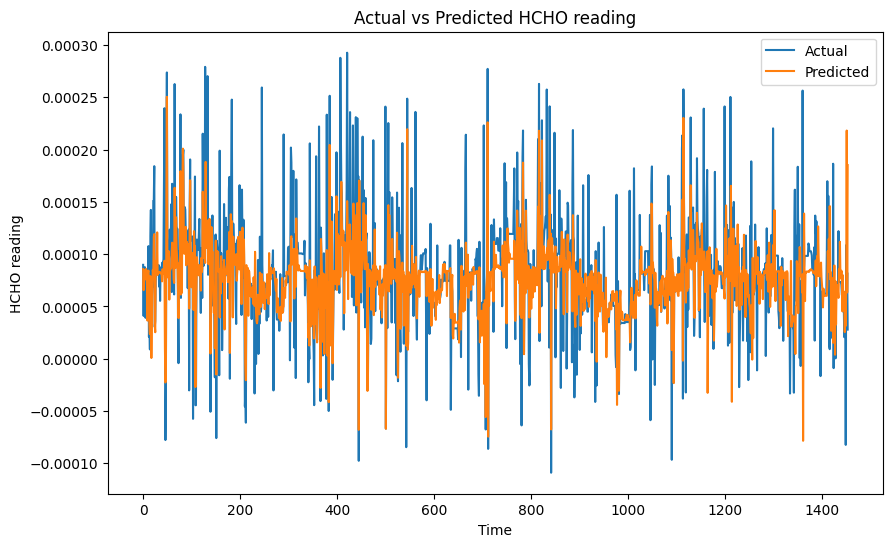

In [519]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_train)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 2s 36ms/step


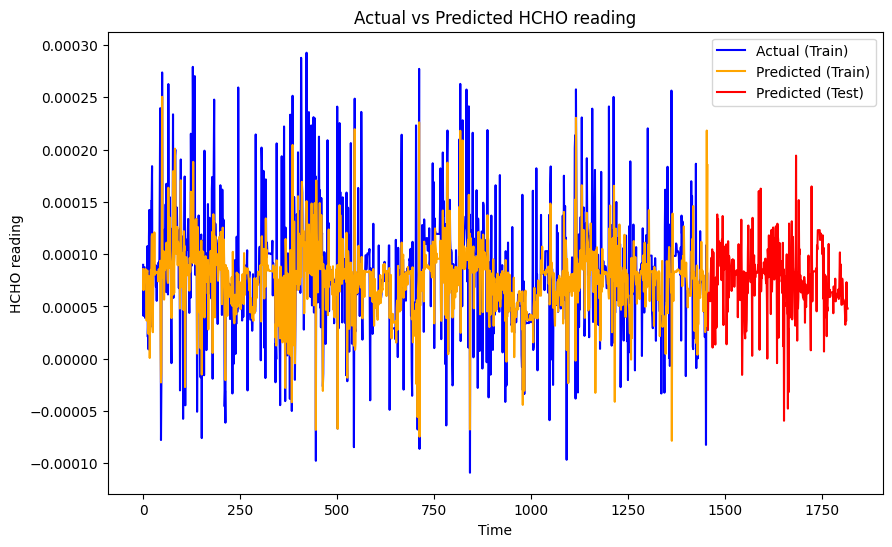

In [520]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler.inverse_transform(predictions_scaled_test)
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler.inverse_transform(predictions_scaled_train)
actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_train, label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [521]:
y_test = actual
predicted_values = predictions.reshape(-1, 1)
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.4211522496337512
Mean Absolute Error (MAE): 2.6203868793166935e-05
Mean Squared Error (MSE): 1.6433697115688217e-09
Root Mean Squared Error (RMSE): 4.053849666143062e-05
Median Absolute Error: 1.566590556344012e-05
Explained Variance Score: 0.43578498019009415


19:15:26 - cmdstanpy - INFO - Chain [1] start processing
19:15:26 - cmdstanpy - INFO - Chain [1] done processing


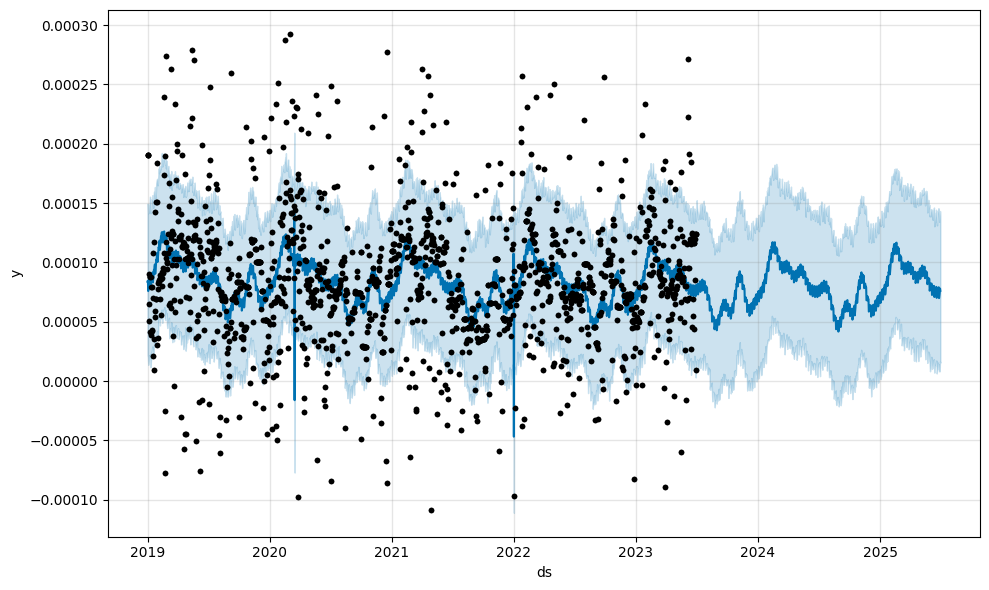

In [302]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare your data
data = pd.read_csv("../NullValueHandled/NuwaraEliyaHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data.rename(columns={'Current Date': 'ds', 'HCHO reading': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

# Define holidays
holidays = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(['2020-03-15', '2021-12-31']), 
    'lower_window': 0,
    'upper_window': 1,
})

train_size = int(0.9 * len(data)) 
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Initialize and fit the Prophet model with holidays
model = Prophet(holidays=holidays) 
model.fit(train_data)

# Create a dataframe for future dates predictions
future = model.make_future_dataframe(periods=730)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
ax = fig1.gca()

# Overlay actual data
ax.plot(train_data['ds'], train_data['y'], 'k.', label='Actual Data')

plt.show()

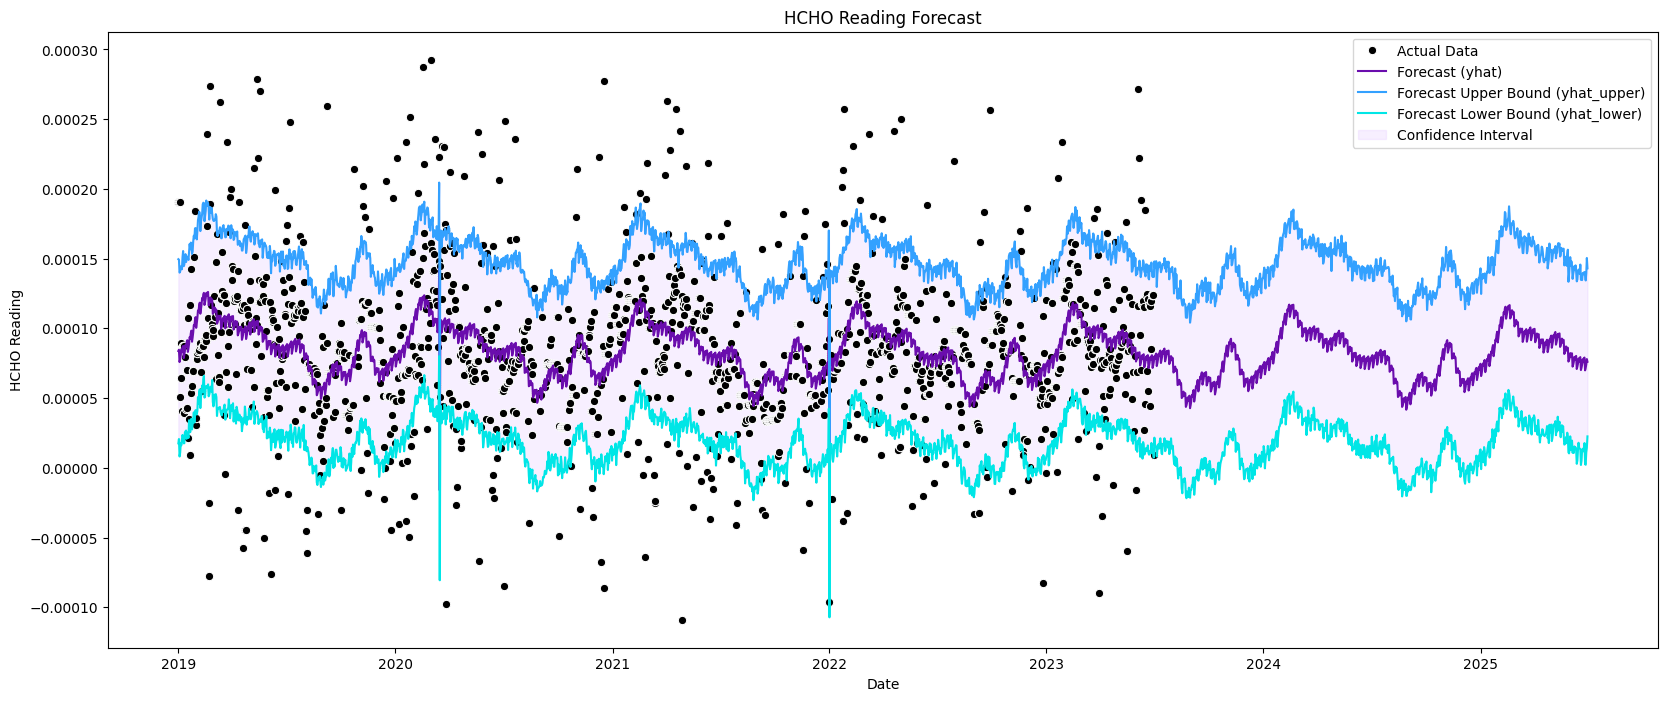

In [284]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))

# Plot actual data
sns.lineplot(data=train_data, x='ds', y='y', label='Actual Data', color='black', marker='o', linestyle='None')

# Plot yhat - forecast
sns.lineplot(data=forecast, x='ds', y='yhat', label='Forecast (yhat)', color='#6a0dad')  # Purple

# Plot yhat_upper
sns.lineplot(data=forecast, x='ds', y='yhat_upper', label='Forecast Upper Bound (yhat_upper)', color='#33a1ff')  # Teal

# Plot yhat_lower
sns.lineplot(data=forecast, x='ds', y='yhat_lower', label='Forecast Lower Bound (yhat_lower)', color='#00e6e6')  # Light Teal

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#d9b3ff', alpha=0.2, label='Confidence Interval')  # Light Purple

plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('HCHO Reading Forecast')

# Adjust legend
plt.legend()

plt.show()

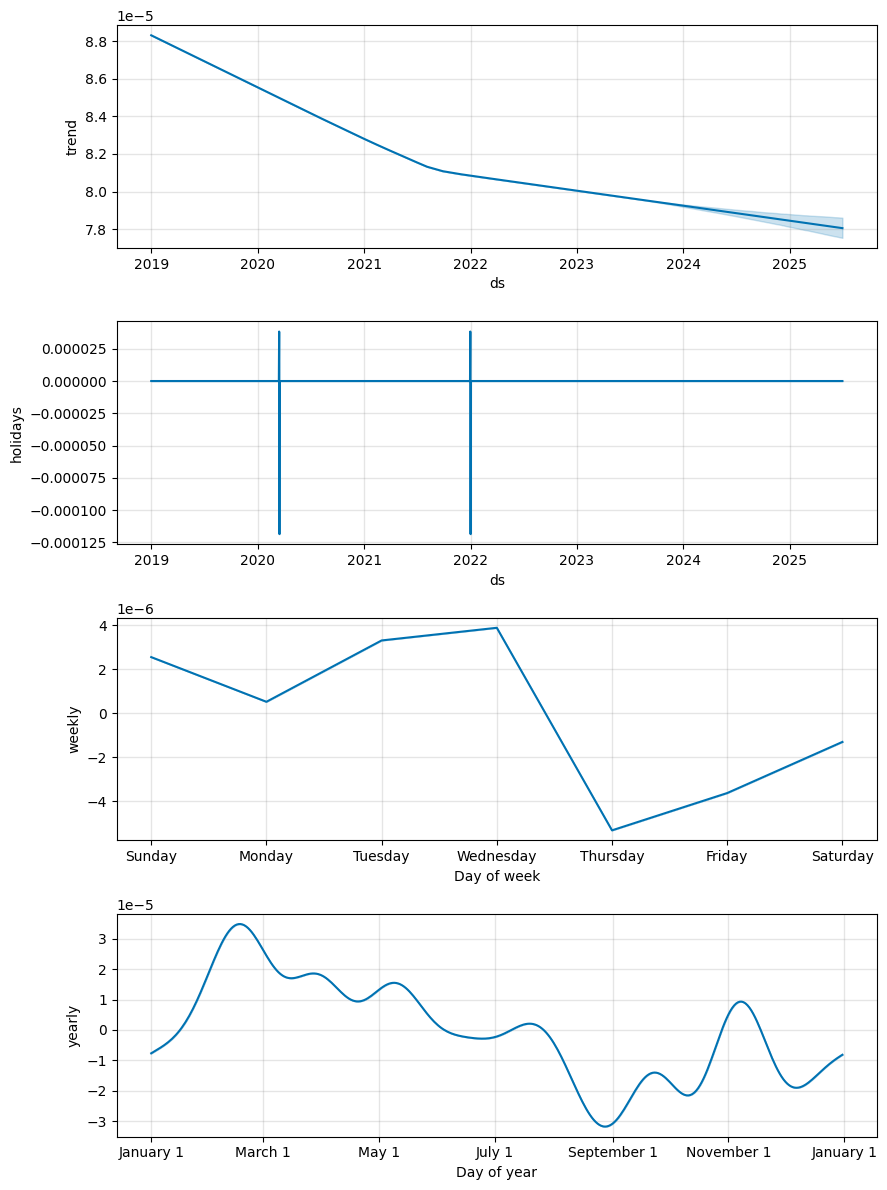

In [285]:
# Plot the forecast components
fig2 = model.plot_components(forecast)

In [286]:
from tabulate import tabulate

y_test = test_data['y']
predicted_values = forecast.loc[forecast['ds'].isin(test_data['ds']), 'yhat']  # Extract forecasted values for test period
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): -0.03332473696988747
Mean Absolute Error (MAE): 4.640746178003005e-05
Mean Squared Error (MSE): 4.394006741650661e-09
Root Mean Squared Error (RMSE): 6.628730452847408e-05
Median Absolute Error: 2.999635321502574e-05
Explained Variance Score: -0.013782492770155974


In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare your data
data = pd.read_csv("../NullValueHandled/BibileMonaragalaHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data.rename(columns={'Current Date': 'ds', 'HCHO reading': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

# Define holidays
holidays = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(['2020-03-15', '2021-12-31']), 
    'lower_window': 0,
    'upper_window': 1,
})

train_size = int(0.90 * len(data)) 
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Initialize and fit the Prophet model with holidays
model = Prophet(holidays=holidays,) 
model.fit(train_data)

# Create a dataframe for future dates predictions
future = model.make_future_dataframe(periods=365)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
ax = fig1.gca()

# Overlay actual data
ax.plot(train_data['ds'], train_data['y'], 'k.', label='Actual Data')

plt.show()